<a href="https://colab.research.google.com/github/agbaysa/Python-Code/blob/master/Akulaku_ensemble1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:



from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/akulaku/_aku3.csv', encoding='latin1')

df.head(3)

Mounted at /content/gdrive


,UID,Loan Amount,Loan Period,Amortization (approximately),Length of Work (Years),Loan granted date,Loan maturity date,Address (Province),Workplace/Business Name,Work Position,Repeat client? Y/N,Outstanding Loan Principal,Outstanding interest,Maximum DPD,Repayment history,Repeat Borrower,Bad,Income
0,509224384239398914,300.00,3,105.00,6,09/27/2023,12/23/2023,BULACAN,Real Estate Renting and Business Services,STAFF,Yes,-,-,0,no delays,N,N,60000.0
1,389245547385851906,300.00,6,55.00,4,09/27/2023,03/23/2024,QUEZON,Real Estate Renting and Business Services,STAFF,Yes,-,-,0,no delays,Y,N,30000.0
2,449995126909943809,300.06,3,105.02,0,09/27/2023,12/23/2023,CAVITE,Blank,Blank,Yes,-,-,0,no delays,N,N,10000.0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:47:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification report for the ensemble model:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     35031
           1       0.73      0.35      0.47      4255

    accuracy                           0.92     39286
   macro avg       0.83      0.67      0.71     39286
weighted avg       0.90      0.92      0.90     39286



<ipython-input-7-9d74169ff963>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X.columns[indices], palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping 

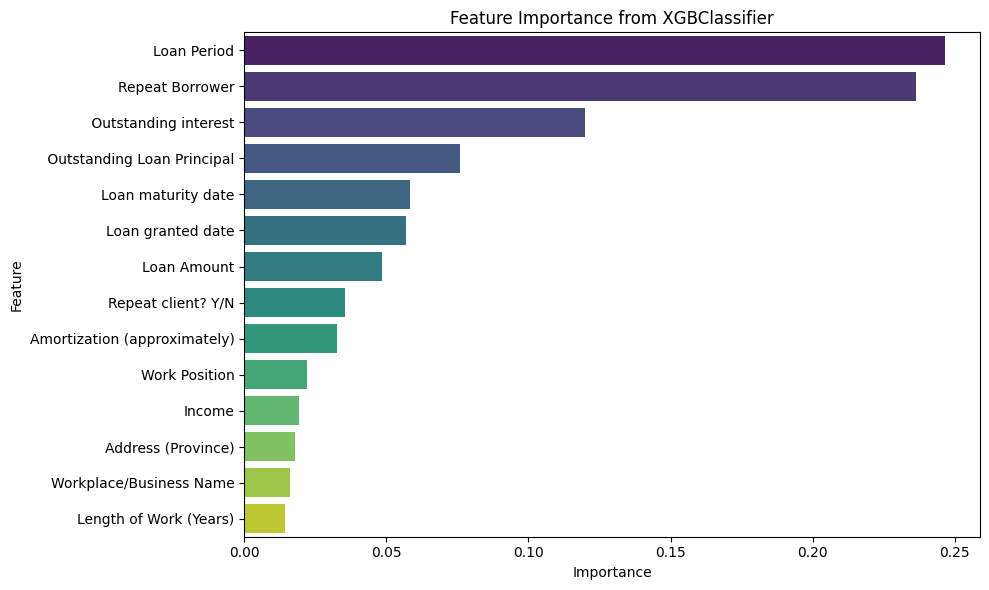

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the target column is named 'Bad'
X = df.drop(columns=['Bad', 'Maximum DPD', 'Repayment history', 'UID'])
y = df['Bad']

# Label encode the target variable
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# Label encode categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns

label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the initial XGBClassifier
model_1 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_1.fit(X_train, y_train)

# Make predictions with the initial model (use predicted probabilities)
y_pred_proba_1_train = model_1.predict_proba(X_train)[:, 1]
y_pred_proba_1_test = model_1.predict_proba(X_test)[:, 1]

# Add the predictions as a new feature for the second model
X_train_meta = np.column_stack((X_train, y_pred_proba_1_train))
X_test_meta = np.column_stack((X_test, y_pred_proba_1_test))

# Train the meta-model (RandomForestClassifier)
model_2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_2.fit(X_train_meta, y_train)

# Make predictions with the meta-model
y_pred_2 = model_2.predict(X_test_meta)

# Classification report for the ensemble model
print("Classification report for the ensemble model:")
print(classification_report(y_test, y_pred_2))

# Plot feature importance of the initial XGBClassifier
importances = model_1.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], palette='viridis')
plt.title('Feature Importance from XGBClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:

# Load a new dataset for making predictions
new_data = pd.read_csv('new_dataset.csv')

# Preprocess the new dataset
for feature in categorical_features:
    if feature in new_data.columns:
        if feature in label_encoders:
            new_data[feature] = label_encoders[feature].transform(new_data[feature])

# Predict using the best model
# Assuming best_model is already trained (from the GridSearchCV)
base_predictions_new = best_model.base_model.predict_proba(new_data)[:, 1]
X_meta_new = np.column_stack((new_data, base_predictions_new))
predictions = best_model.meta_model.predict(X_meta_new)

# Output predictions as a CSV file
output_df = new_data.copy()
output_df['Prediction'] = predictions
output_df.to_csv('predictions_output.csv', index=False)

print("Predictions saved to predictions_output.csv")